### Imports and data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("WineQT.csv")

# Features and target
X_alcohol = df["alcohol"].values.reshape(-1, 1)
X_chlorides = df["chlorides"].values.reshape(-1, 1)

y = df["quality"].values

### Simple  linear regression model using gradient descent 

In [2]:
def gradient_descent(X, y, eta=0.01, n_iterations=1000):
    """
    Simple Linear Regression with Gradient Descent.
    Returns parameters theta = [intercept, slope].
    """
    m = len(y)
    X_b = np.c_[np.ones((m, 1)), X]  # add bias column
    theta = np.random.randn(2, 1) * 0.01    # smaller random init
    
    # Normalize features for stability
    X_mean = np.mean(X_b[:, 1:], axis=0)
    X_std = np.std(X_b[:, 1:], axis=0) + 1e-8  # avoid division by zero
    X_b[:, 1:] = (X_b[:, 1:] - X_mean) / X_std
    
    # Store normalization parameters
    norm_params = (X_mean, X_std)
    
    # Initialize previous cost for convergence check
    prev_cost = float('inf')

    for iteration in range(n_iterations):
        predictions = X_b.dot(theta)
        errors = predictions - y.reshape(-1, 1)
        gradients = (2/m) * X_b.T.dot(errors)
        
        # Check for overflow
        if np.any(np.isnan(gradients)) or np.any(np.isinf(gradients)):
            break
            
        theta -= eta * gradients
        
        # Optional: check convergence
        if iteration % 100 == 0:
            cost = np.mean(errors**2)
            if abs(prev_cost - cost) < 1e-8:
                break
            prev_cost = cost
    
    return theta, norm_params

In [3]:
def evaluate_feature(X, y, feature_name, eta=0.01, n_iterations=1000):
    """
    Performs 5-fold cross-validation using gradient descent and evaluates performance.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    print(f"\nEvaluating {feature_name} with 5-fold cross-validation:")
    print("=" * 60)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train with gradient descent
        theta, norm_params = gradient_descent(X_train, y_train, eta=eta, n_iterations=n_iterations)
        X_mean, X_std = norm_params
        
        # Predict on test set (apply same normalization)
        X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]
        X_test_b[:, 1:] = (X_test_b[:, 1:] - X_mean) / X_std
        y_pred = X_test_b.dot(theta).flatten()

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Fold': fold,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })
        
        print(f"Fold {fold}: MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS:")
    print("=" * 60)
    
    # Calculate summary statistics
    summary_stats = results_df[['MSE', 'RMSE', 'R2']].agg(['mean', 'std', 'min', 'max'])
    print(summary_stats)
    
    return results_df

In [4]:
# Evaluate alcohol feature
print("Training Simple Linear Regression with Gradient Descent")
print("Dataset split: 80% training, 20% testing in 5 different folds")
print(f"Total samples: {len(y)}")

results_alcohol = evaluate_feature(X_alcohol, y, "Alcohol")

Training Simple Linear Regression with Gradient Descent
Dataset split: 80% training, 20% testing in 5 different folds
Total samples: 1143

Evaluating Alcohol with 5-fold cross-validation:
Fold 1: MSE=0.4175, RMSE=0.6462, R²=0.2497
Fold 2: MSE=0.5900, RMSE=0.7681, R²=0.1988
Fold 3: MSE=0.5140, RMSE=0.7169, R²=0.2415
Fold 4: MSE=0.4998, RMSE=0.7070, R²=0.2677
Fold 5: MSE=0.4632, RMSE=0.6806, R²=0.2126

SUMMARY STATISTICS:
           MSE      RMSE        R2
mean  0.496919  0.703764  0.234051
std   0.064027  0.045213  0.027989
min   0.417547  0.646179  0.198839
max   0.589982  0.768103  0.267703


In [5]:
# Evaluate chlorides feature
results_chlorides = evaluate_feature(X_chlorides, y, "Chlorides")


Evaluating Chlorides with 5-fold cross-validation:
Fold 1: MSE=0.5591, RMSE=0.7478, R²=-0.0048
Fold 2: MSE=0.7266, RMSE=0.8524, R²=0.0133
Fold 3: MSE=0.6591, RMSE=0.8118, R²=0.0274
Fold 4: MSE=0.6658, RMSE=0.8160, R²=0.0246
Fold 5: MSE=0.5916, RMSE=0.7692, R²=-0.0057

SUMMARY STATISTICS:
           MSE      RMSE        R2
mean  0.640453  0.799430  0.010953
std   0.065987  0.041303  0.015715
min   0.559137  0.747755 -0.005712
max   0.726643  0.852434  0.027417


In [6]:
# Compare results between features
print("\n" + "="*80)
print("COMPARISON OF FEATURES")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Feature': ['Alcohol', 'Chlorides'],
    'Mean_MSE': [results_alcohol['MSE'].mean(), results_chlorides['MSE'].mean()],
    'Mean_RMSE': [results_alcohol['RMSE'].mean(), results_chlorides['RMSE'].mean()],
    'Mean_R2': [results_alcohol['R2'].mean(), results_chlorides['R2'].mean()],
    'Std_MSE': [results_alcohol['MSE'].std(), results_chlorides['MSE'].std()],
    'Std_RMSE': [results_alcohol['RMSE'].std(), results_chlorides['RMSE'].std()],
    'Std_R2': [results_alcohol['R2'].std(), results_chlorides['R2'].std()]
}

comparison_df = pd.DataFrame(comparison_data)
print("Performance Comparison:")
print(comparison_df.round(4))

# Determine better feature
if comparison_df.loc[0, 'Mean_R2'] > comparison_df.loc[1, 'Mean_R2']:
    better_feature = "Alcohol"
    better_r2 = comparison_df.loc[0, 'Mean_R2']
else:
    better_feature = "Chlorides"
    better_r2 = comparison_df.loc[1, 'Mean_R2']

print(f"\nBest performing feature: {better_feature} (R² = {better_r2:.4f})")


COMPARISON OF FEATURES
Performance Comparison:
     Feature  Mean_MSE  Mean_RMSE  Mean_R2  Std_MSE  Std_RMSE  Std_R2
0    Alcohol    0.4969     0.7038   0.2341    0.064    0.0452  0.0280
1  Chlorides    0.6405     0.7994   0.0110    0.066    0.0413  0.0157

Best performing feature: Alcohol (R² = 0.2341)


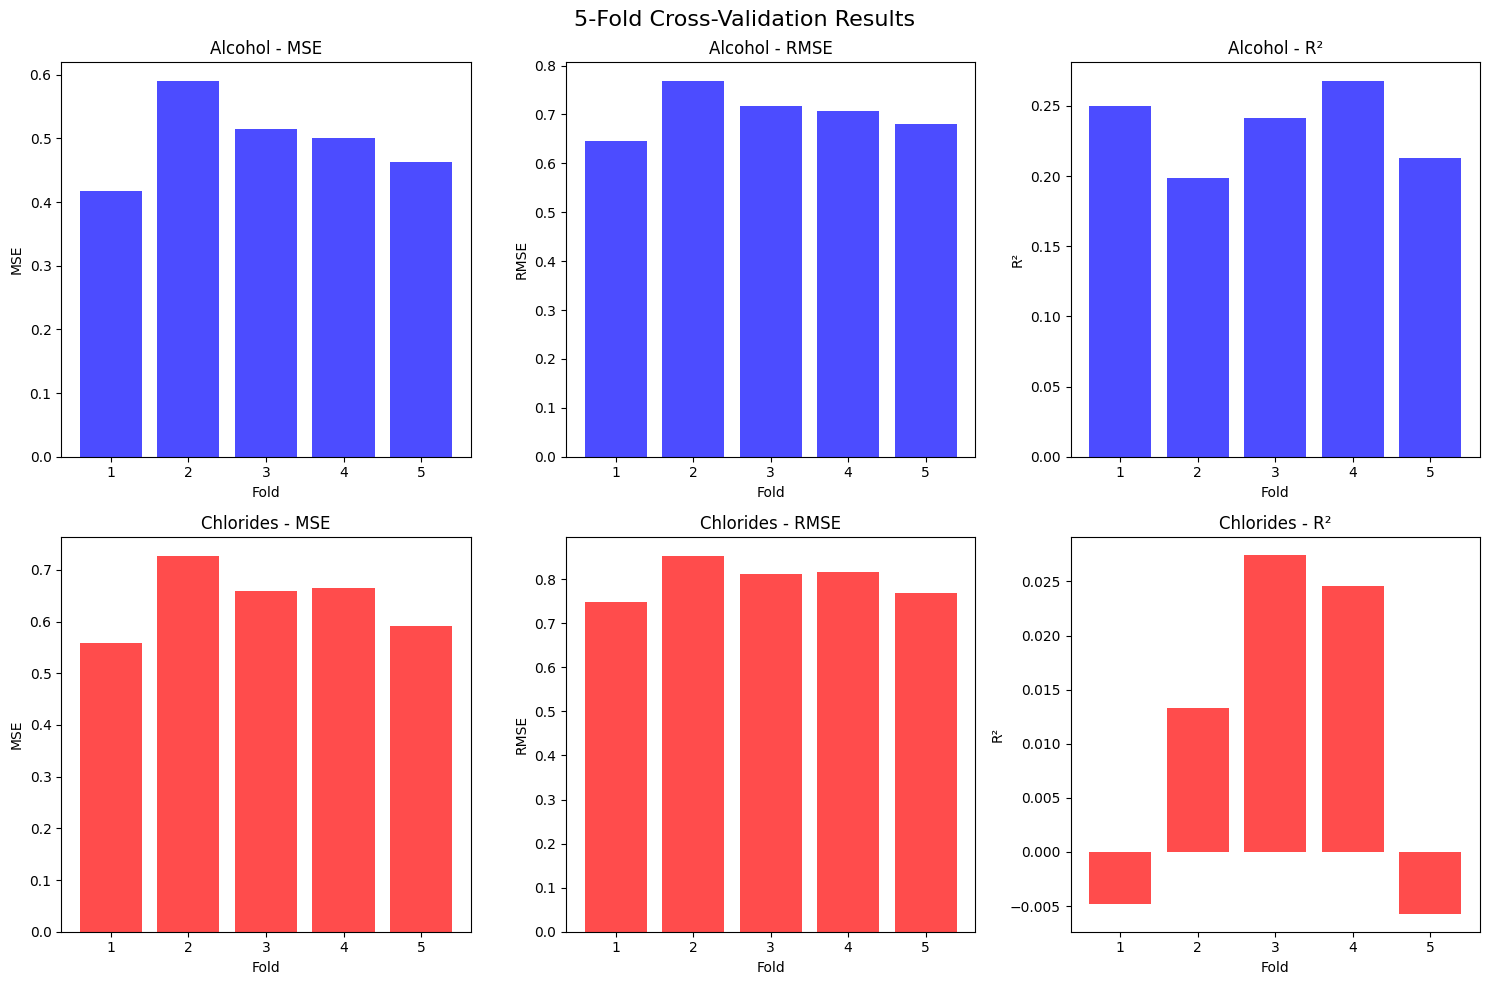

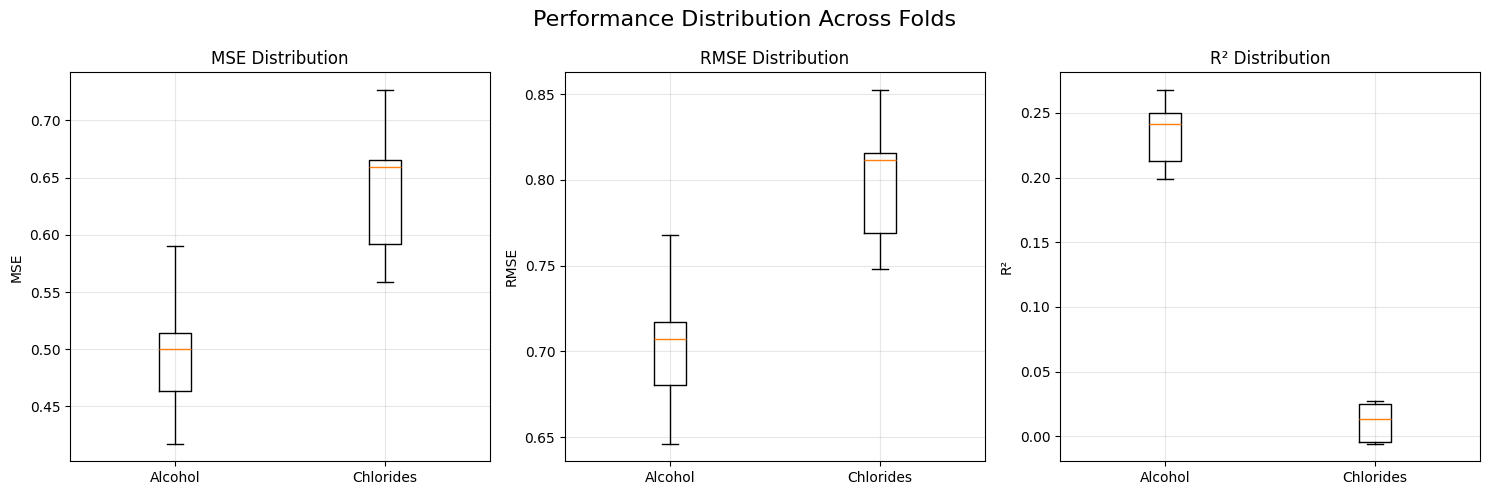

In [7]:
# Visualize results across folds
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('5-Fold Cross-Validation Results', fontsize=16)

# Prepare data for plotting
alcohol_data = [results_alcohol['MSE'].values, results_alcohol['RMSE'].values, results_alcohol['R2'].values]
chlorides_data = [results_chlorides['MSE'].values, results_chlorides['RMSE'].values, results_chlorides['R2'].values]
metrics = ['MSE', 'RMSE', 'R²']
folds = range(1, 6)

# Plot metrics for each feature
for i, metric in enumerate(metrics):
    # Alcohol
    axes[0, i].bar(folds, alcohol_data[i], alpha=0.7, color='blue', label='Alcohol')
    axes[0, i].set_title(f'Alcohol - {metric}')
    axes[0, i].set_xlabel('Fold')
    axes[0, i].set_ylabel(metric)
    axes[0, i].set_xticks(folds)
    
    # Chlorides
    axes[1, i].bar(folds, chlorides_data[i], alpha=0.7, color='red', label='Chlorides')
    axes[1, i].set_title(f'Chlorides - {metric}')
    axes[1, i].set_xlabel('Fold')
    axes[1, i].set_ylabel(metric)
    axes[1, i].set_xticks(folds)

plt.tight_layout()
plt.show()

# Box plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Performance Distribution Across Folds', fontsize=16)

metrics_data = [
    [results_alcohol['MSE'].values, results_chlorides['MSE'].values],
    [results_alcohol['RMSE'].values, results_chlorides['RMSE'].values],
    [results_alcohol['R2'].values, results_chlorides['R2'].values]
]

for i, metric in enumerate(metrics):
    axes[i].boxplot(metrics_data[i], tick_labels=['Alcohol', 'Chlorides'])
    axes[i].set_title(f'{metric} Distribution')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()